# Import

In [1]:
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn

import numpy as np


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random 

In [2]:
random.seed(3)

In [3]:
n_input = 10
X = tf.placeholder(tf.float32, shape=[None, 16])
Z = tf.placeholder(tf.float32, [None, n_input])

# Set up parameters for generator and discriminator

In [4]:
# Generator
# Define the variables for the generator, we will use them to build layers later
# -------------------
n_hidden = 5
vocab_size = 16
weights = {'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]),dtype=tf.float32)}
biases  = {'out': tf.Variable(tf.random_normal([vocab_size]),dtype=tf.float32)}
# theta_G and theta_D will be feeded to different optimizers later as "var_list", 
# since currently we have two networks instead of one now.
theta_G = [weights, biases]


# ====================
# Discriminator
# Define the variables for the discriminator
# --------------------
size_d_w1 = 16
size_d_b1 = 8
w1_std = 1.0/tf.sqrt(size_d_w1/2.0)

D_W1 = tf.Variable(tf.random_normal(shape=[size_d_w1,size_d_b1], stddev=w1_std))
D_b1 = tf.Variable(tf.zeros(shape=[size_d_b1]))

size_d_w2 = 8
size_d_b2 = 1
w2_std = 1.0/tf.sqrt(size_d_w2/2.0)

D_W2 = tf.Variable(tf.random_normal(shape=[size_d_w2,size_d_b2], stddev=w2_std))
D_b2 = tf.Variable(tf.zeros(shape=[size_d_b2]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Instructions for updating:
Colocations handled automatically by placer.


# Generator module

In [5]:
def generator(z, reuse = False):
    
    with tf.variable_scope('generator', reuse = reuse ) as vs:
        if reuse:
                vs.reuse_variables()
        #z = tf.convert_to_tensor(z)
        z = tf.reshape(z, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        # (e.g. [A] [slave] [named] -> [9] [10] [37])
        z = tf.split(z,n_input,1)
        
        # basic RNN cell
        #rnn_cell = rnn.BasicRNNCell(n_hidden)
    
        # 1-layer LSTM with n_hidden units
        rnn_cell = rnn.BasicLSTMCell(n_hidden, reuse=reuse )
        
        # 2-layer LSTM, each layer has n_hidden units. And you can wrap more layers together by doing list comprehension.
        #rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden),rnn.BasicLSTMCell(n_hidden)])
    
        # 3-layer LSTM, each layer has n_hidden units. 
        # And you can wrap more layers together by doing list comprehension.
        #rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden),rnn.BasicLSTMCell(n_hidden),rnn.BasicLSTMCell(n_hidden)])
    
        # generate prediction
        # creates a recurrent neural network specified by RNNCell cell
        outputs, states = rnn.static_rnn(rnn_cell, z, dtype=tf.float32)
    
        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

# Discriminator module

In [6]:
def discriminator(x):

    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Generate samples function

In [7]:
def sample_z(m, n):
    # randomly generate samples for generator
    return np.random.uniform(-1.0, 1.0, size = [m, n]).astype('float32')

# Faciliate the path defining process

In [8]:
# Though it's not possible to get the path to the notebook by __file__, os.path is still very useful in dealing with paths and files
# In this case, we can use an alternative: pathlib.Path
"""
code_dir   = os.path.dirname(__file__)
"""

from pathlib import Path
#get the current path of our code
code_dir = Path().resolve()
#create output_dir within the same path
output_dir = os.path.join(code_dir, 'outputGANs/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# Build GNN with defined vars and functions

In [9]:
# Put randomly generated sample Z into the generator to create "fake" images
G_sample = generator(Z)
# The result of discriminator of real and fake samples
_, D_logit_real = discriminator(X)
_, D_logit_fake = discriminator(G_sample)

# generator loss 
# the goal of generator is to let discriminator make more mistakes on fake samples
# tf.ones_like returns a tensor with all elements set to 1
# 0 represent fake and 1 means real
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_solver = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(G_loss)

# discriminator loss 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [11]:
import pandas as pd
cwd = os.getcwd()
raw = pd.read_csv(cwd+'/Normalized_GSPC.csv', index_col = 0)
x_min = raw.min()
x_max = raw.max()

def data_generator(data_path, seq_length):
    """
    Args:
        seq_length: Length of the finance data (or we could refer it as receptive field length)
    """
    raw = pd.read_csv(data_path)
    ####Normalize into -1 and 1
    normalize_raw = raw.clip(lower=-1, upper=1)
    
    ###Rolling Window###
    X_data = normalize_raw["Y1.X"][:-seq_length]
    
    ###Create sequence###
    X = list()
    for i in range(len(X_data)-seq_length+1):
        X.append(X_data[i:i+seq_length])
        
    
    ###Transfer to Tensor###
    #X_tensor = tf.convert_to_tensor(np.array(X), dtype=np.float64)
    
    return np.array(X).astype('float32')

X_tensor = data_generator(cwd+'/Normalized_GSPC.csv', 16)
X_dataset = tf.data.Dataset.from_tensor_slices(X_tensor)

class Dataset:

    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass
    
    
    @property
    def data(self):
        return self._data
    
    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples
    
        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples
    
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]

X_train = Dataset(X_tensor)

In [12]:
x_min = raw.min()
x_max = raw.max()

In [13]:
import pandas as pd
df = pd.read_csv(cwd+"/Normalized_GSPC.csv")
data = df['Y1.X']
window_size=16
x, y = [], []
for l in range(0,len(data)-window_size):
    x.append(np.array(data.iloc[l:l+window_size]))
    y.append([np.array(data.iloc[l+window_size]),0])
x, y = np.array(x).reshape(len(data)-window_size,window_size),np.array(y).reshape(len(data)-window_size,2)

In [14]:
x = x.astype(dtype = 'float32')
y = y.astype(dtype = 'float32')

In [15]:
len(X_tensor)

2402

# Start the session

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 4
# the dimension of the random samples
z_dim = 10
result_freq = 10
# plot generators' output every figure_iter step
figure_iter = 1
max_iter = int(len(X_tensor)/batch_size)*100
size1 = 5
size2 = 5
i = 0
accuracy = 0.0001
output = list()
dloss_list = list()
gloss_list = list()
for iter in range(max_iter):
    

        
    
    # G_sample is a sample from the generator
    res = generator(sample_z(batch_size, z_dim), reuse = True).eval(session=sess)

    output.append(res)
    #plt.savefig(output_dir + 'GANs' + str(i) + '.png', bbox_inches='tight')
    i += 1
    #plt.close(fig1)

    batch_xs = X_train.next_batch(batch_size)
    
    

    _, discriminator_loss = sess.run([D_solver, D_loss], feed_dict={X: batch_xs, Z: sample_z(batch_size, z_dim)})
    _, generator_loss     = sess.run([G_solver, G_loss], feed_dict={Z: sample_z(batch_size, z_dim)})
    
    dloss_list.append(discriminator_loss)
    gloss_list.append(generator_loss)
    
    
    
    if iter % result_freq == 0:
        print('iteration: {}'.format(iter))
        print('D_loss: {:0.4}'.format(discriminator_loss))
        print('G_loss: {:0.4}'.format(generator_loss))
        print()
        
    

iteration: 0
D_loss: 1.319
G_loss: 0.7996

iteration: 10
D_loss: 1.016
G_loss: 0.8453

iteration: 20
D_loss: 1.359
G_loss: 0.8245

iteration: 30
D_loss: 0.8879
G_loss: 0.7817

iteration: 40
D_loss: 1.126
G_loss: 0.8701

iteration: 50
D_loss: 1.525
G_loss: 0.7635

iteration: 60
D_loss: 1.431
G_loss: 0.7139

iteration: 70
D_loss: 1.203
G_loss: 0.6724

iteration: 80
D_loss: 1.28
G_loss: 0.7739

iteration: 90
D_loss: 1.311
G_loss: 0.6579

iteration: 100
D_loss: 1.139
G_loss: 0.6214

iteration: 110
D_loss: 1.211
G_loss: 0.5597

iteration: 120
D_loss: 1.373
G_loss: 0.5403

iteration: 130
D_loss: 1.299
G_loss: 0.5356

iteration: 140
D_loss: 1.388
G_loss: 0.5446

iteration: 150
D_loss: 1.44
G_loss: 0.4884

iteration: 160
D_loss: 1.499
G_loss: 0.5014

iteration: 170
D_loss: 1.366
G_loss: 0.4658

iteration: 180
D_loss: 1.303
G_loss: 0.4732

iteration: 190
D_loss: 1.497
G_loss: 0.4567

iteration: 200
D_loss: 1.435
G_loss: 0.417

iteration: 210
D_loss: 1.373
G_loss: 0.4108

iteration: 220
D_loss: 

In [16]:
generate_data = list()
for i in range(len(output)):
    generate_data = generate_data+list(output[i])

In [18]:
len(generate_data)

240000

In [19]:
generated_df = pd.DataFrame(generate_data)

In [20]:
generated_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.285271,0.135999,-1.132246,0.520327,-0.949350,-0.547025,0.376624,0.920530,-0.861165,-0.881887,0.131811,0.231540,0.236930,1.355924,2.298860,-1.470330
1,-0.551013,0.180510,-1.314762,1.442168,-0.620766,-0.049994,0.135957,0.851034,-1.000699,-0.743005,-0.009712,-0.399820,-0.444615,1.510141,1.758686,-1.423818
2,-0.512295,0.164429,-1.317003,1.482492,-0.594783,-0.030465,0.109018,0.853318,-0.980975,-0.764018,0.044000,-0.418901,-0.434198,1.509552,1.716941,-1.428697
3,-0.491642,0.326574,-1.240836,0.971447,-0.864022,-0.154549,0.082035,0.940132,-0.930211,-0.972143,-0.037282,-0.280030,-0.420884,1.328518,1.863435,-1.391608
4,-0.343171,0.139369,-1.168679,0.754398,-0.880550,-0.432180,0.316264,0.898054,-0.891561,-0.846393,0.115672,0.076723,0.073669,1.390046,2.140572,-1.455915


In [21]:
generated_df.to_csv("generated_lstm.csv")

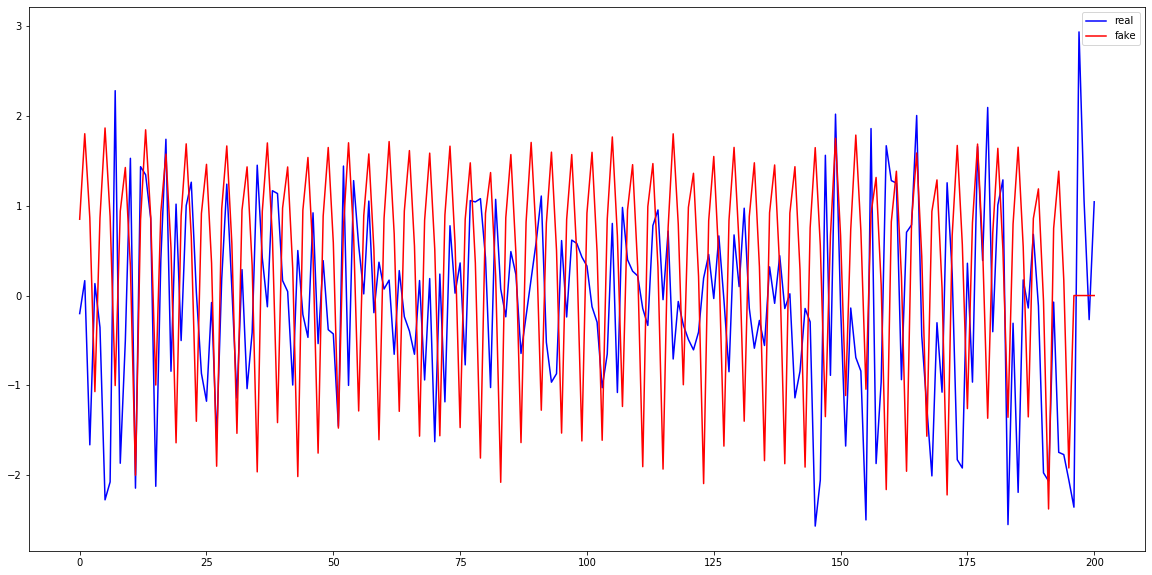

In [30]:
plt.figure(figsize=(20,10))
plt.plot(y[554*4:,0],color='b',label='real')
plt.plot(y[554*4:,1],color='r',label='fake')
plt.legend()
